# Example on how to use the LSST stack Butler on electro-optical Camera test stand data
This notebook shows how to use the LSST Butler to display and analyze raw test stand data.  We'll start with how to run and isolate specific ISR tasks, then start to look at raw pixel values at an amp by amp basis.  This is mostly a copy (except for the last few cells) based on Robert Lupton's demo notebook: 

https://github.com/RobertLuptonTheGood/notebooks/blob/master/Demos/Looking%20at%20Teststand%20Data.ipynb

## Last sucessful run with w_2018_22, on June 5, 2018

First, let's do some importing and setup.

In [112]:
import numpy as np
import lsst.daf.persistence as dafPersist
from lsst.ip.isr import AssembleCcdTask    # force an import of pcaPsfDeterminer.py (which selects ds9) (DM-13432)
import lsst.afw.cameraGeom.utils as cameraGeomUtils
import lsst.afw.display as afwDisplay
import matplotlib.pyplot as plt

%matplotlib inline 
#%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

#%matplotlib qt
#%gui qt

I've chosen to use matplotlib, but can probably use ds9 or firefly instead.

In [113]:
afwDisplay.setDefaultBackend("matplotlib" if True else "ds9")


Point at the pre-ingested repository.  This one is a subset of RTM5 TS8 data (2 runs).  Currently, the only keys are run, visit, ccd.  There is currently just a 1-1 formula to translate MJD of the exposure to that visit number, or more useful vice-versa is:  $MJD = 55197 + visitnum*100000$.  In the future we'll have more keys in the butler in order to better ID exposures!

In [114]:
dataPath = "/datasets/comCam/repo/rtm5"

butler = dafPersist.Butler(dataPath)
print("Available runs: %s" % (" ".join(butler.queryMetadata('raw', ['run']))))  # available runs
print("Available visits: %s" % ("".join(str(butler.queryMetadata('raw', ['run','visit'][1]))))) # available visits in run 4417
visits=butler.queryMetadata('raw', ['run','visit'][1])  # to get a list of visits in run 4417
mjds=[(float(visit)*1e-5)+55197 for visit in visits]  # calulate the MJD time for each visit


Available runs: 4389 4417
Available visits: [269892434, 269892463, 269892490, 269892518, 269892546, 269892754, 269893006, 269893257, 269893506, 269893758, 269894410, 269894435, 269894460, 269894486, 269894511, 269895155, 269895842, 269896528, 269897215, 269897641, 269897766, 269897868, 269898025, 269898090, 269898188, 269898352, 269898421, 269898519, 269898672, 269898739, 269898839, 269898990, 269899061, 269899165, 269899318, 269899393, 269899499, 269899657, 269899741, 269899873, 269900034, 269900138, 269900295, 269900467, 269900591, 269900779, 269900952, 269901093, 269901286, 269901461, 269901621, 269901834, 269902006, 269902185, 269902421, 269902593, 269902781, 269903020, 269903193, 269903386, 269903637, 269903818, 269904021, 269904279, 269904452, 269904670, 269904946, 269905122, 269905355, 269905642, 269905818, 269906074, 269906382, 269908130, 269908156, 269908183, 269908208, 269908234, 269908260, 269908286, 269908311, 269908337, 269908363, 269908389, 269908414, 269908438, 269908465

Another way to get a dataId would be to look at the various other metadata, but is not well documented what is available...  at least imageType (FLAT, BIAS, DARK), and wavelength (monochromator setting).

In [115]:
butler.queryMetadata('raw', ['visit', 'run'], imageType='FLAT', wavelength=800)

[(269919558, '4389'), (270022788, '4417')]

In our first example, we'll be using the photon transfer curve (PTC) data with visit idx: 19 -- 72 of run 4417, in order: bias, flat1, flat2, repeat...

In [116]:
ptc_visits=visits[19:73]

The camera description has all the various particulars of the raft-level data (defined under the comcam obs package).
https://github.com/lsst/obs_comCam

In [117]:
camera = butler.get("camera")

For looking at a specific CCD, can either do a butler.get:

In [118]:
ptc_visit = ptc_visits[53]  # this is the last flat in the PTC run
dataId = dict(visit=ptc_visit, ccd='S11')
raw = butler.get('raw',dataId)

And we can display it like:

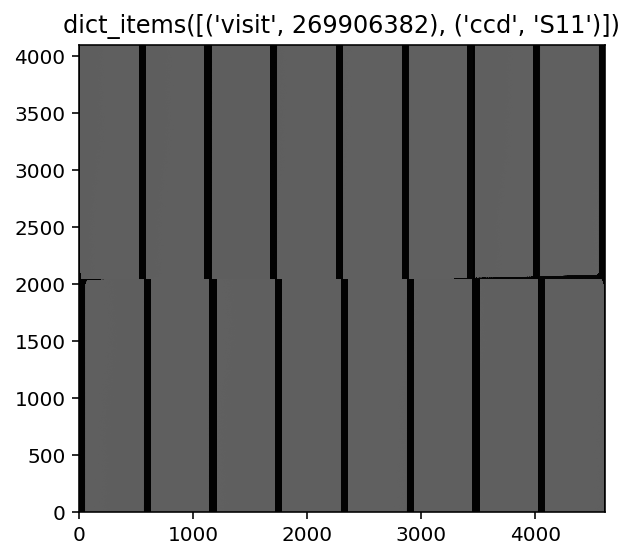

In [119]:
disp = afwDisplay.Display(1)
disp.scale('asinh','zscale')
disp.mtv(raw, title=dataId.items())

The camera description can overlay some interesting info (prescan, overscan, data).  And we zoom in.  

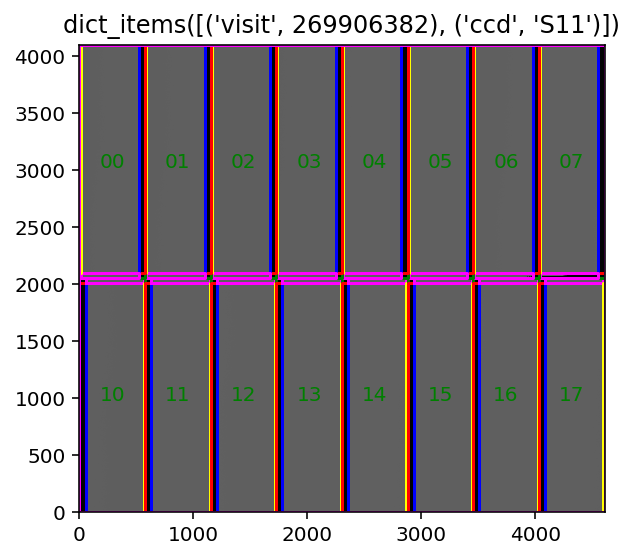

In [120]:
disp = afwDisplay.Display(1)    # you only need this in every cell because I'm using %matplotlib notebook. DM Bug??
disp.scale('asinh', 'zscale')

disp.mtv(raw, title=dataId.items())
cameraGeomUtils.overlayCcdBoxes(raw.getDetector(), display=disp)

Now we want to do something with this raw data.  First let's do the "normal" raw processing which is subtract (median overscan) the bias, trim the frame, convert to electrons.  This is done here as a "callback" in the butler image call and display it in the same line.

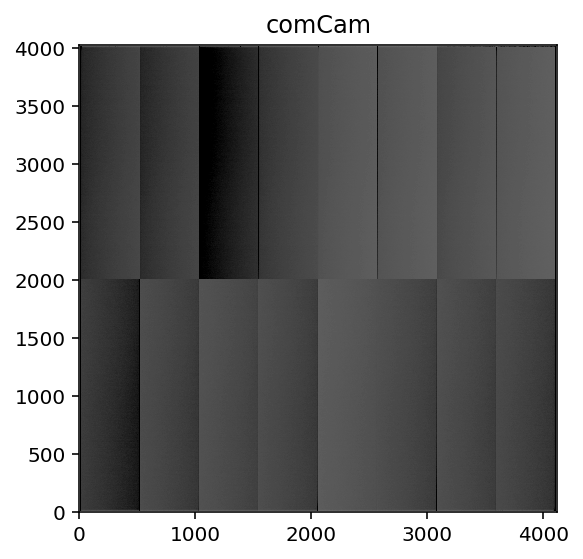

In [121]:
disp = afwDisplay.Display(1)
disp.scale('asinh', 'zscale')

cameraGeomUtils.showCamera(camera,
                           cameraGeomUtils.ButlerImage(butler, "raw", visit=dataId["visit"],
                                                       callback=cameraGeomUtils.rawCallback),
                                 binSize=1, detectorNameList=[dataId["ccd"]], overlay=False, display=disp);

Or do this on the whole raft:

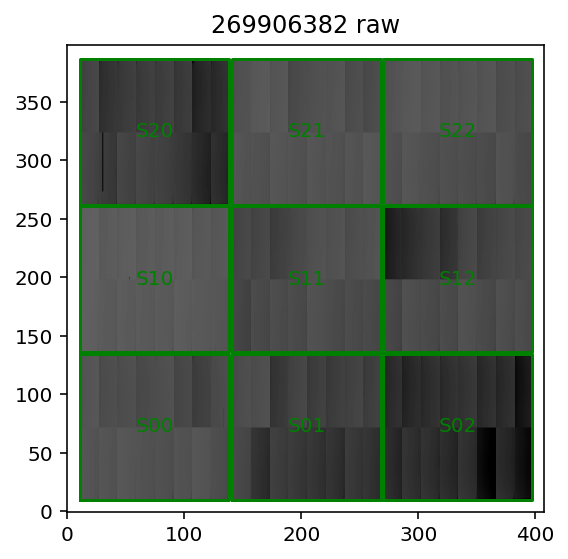

In [122]:
disp = afwDisplay.Display(1)
disp.scale('asinh', 'zscale')

dataType = "raw"
mos = cameraGeomUtils.showCamera(camera,
                                 cameraGeomUtils.ButlerImage(butler, dataType, visit=dataId["visit"],
                                                             callback=cameraGeomUtils.rawCallback),
                                 binSize=32, display=disp, title="%d %s" % (ptc_visit, dataType))

If we want to do specific things in the processing we can define a custom callback:

In [123]:
def myCallback(im, ccd, imageSource, subtractMedian=True):
    """Assemble the CCD image, subtracting the overscan and subtracting each amp's median"""

    oim = cameraGeomUtils.rawCallback(im, ccd, imageSource,
                                       subtractBias=True, correctGain=False)
    if subtractMedian:
        for a in ccd:
            arr = oim[a.getBBox()].array
            arr -= np.median(arr)

    return oim

And display it:

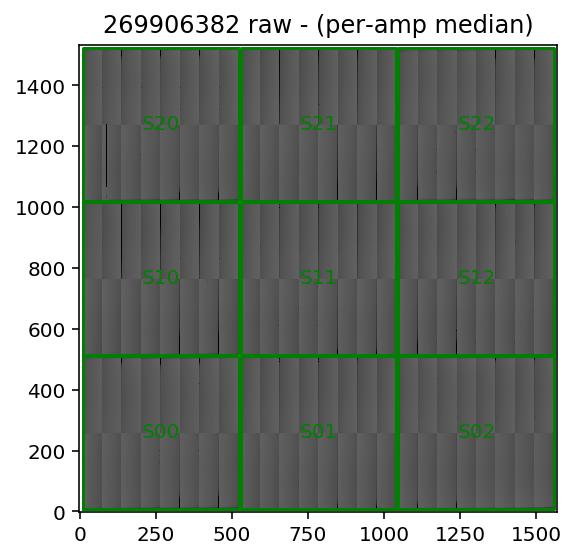

In [124]:
disp = afwDisplay.Display(1)
disp.scale('asinh', 'zscale')

dataType = "raw"
mos = cameraGeomUtils.showCamera(camera,
                                 cameraGeomUtils.ButlerImage(butler, dataType, visit=dataId["visit"],
                                                             callback=myCallback),
                                 binSize=8, display=disp, title="%d %s - (per-amp median)" % (ptc_visit, dataType))

An alternative way is to just run the processing independently through AssembleCcdTask.  For example, just trim the [pre+over]scan

{'doTrim': True, 'keysToRemove': []}


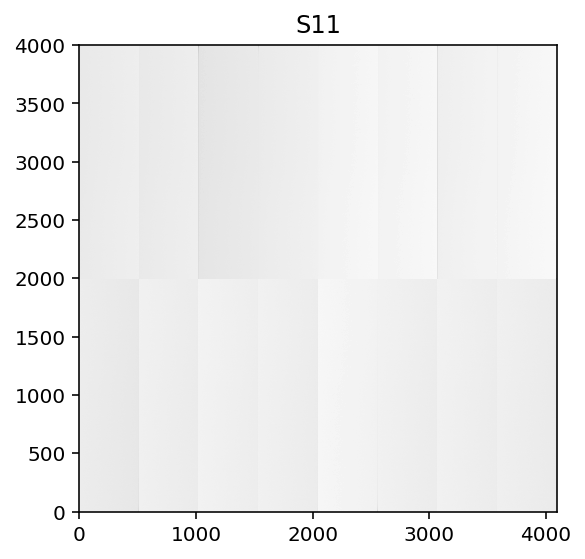

In [126]:
from lsst.ip.isr import AssembleCcdTask

config = AssembleCcdTask.ConfigClass()          # Configuration options
config.doTrim = True


assembleTask = AssembleCcdTask(config=config)   # Build the Task object

exposure = assembleTask.assembleCcd(raw)        # Do the work.

disp = afwDisplay.Display(1)

disp.mtv(exposure, title=dataId["ccd"])
print(config)

Okay, now let's try to get a PTC plot.  First let's define a set (bias, flat1, flat2) of exposures.

In [127]:
dataId0 = dict(visit=ptc_visits[0], ccd='S11') # bias
dataId1 = dict(visit=ptc_visits[1], ccd='S11') # flat1
dataId2 = dict(visit=ptc_visits[2], ccd='S11') # flat2

bias = butler.get('raw', dataId0)
flat1 = butler.get('raw', dataId1)
flat2 = butler.get('raw', dataId2)

Then there are multiple ways to get a the amplifiers.  First is to use the camera definition, another way is to use the raw_amp butler object.

In [128]:
amp=raw0.getDetector()[8]  # pick the 9th amplifier

print(np.mean( (flat1[amp.getBBox()].image.array-bias[amp.getBBox()].image.array) ) )
print(np.std( (flat1[amp.getBBox()].image.array-flat2[amp.getBBox()].image.array) )**2)

# or (potentially) alternatively, I can't get the getBBox to give image box without pre/over scans...

#bias_amp = butler.get("raw_amp", run=4389, visit=ptc_visits[0], ccd='S11', channel=8)
#flat1_amp = butler.get("raw_amp", run=4389, visit=ptc_visits[1], ccd='S11', channel=8)
#flat2_amp = butler.get("raw_amp", run=4389, visit=ptc_visits[2], ccd='S11', channel=8)
#ampbox=bias_amp.getBBox()
#print(np.mean( (flat1_amp[ampbox].image.array-bias_amp[ampbox].image.array) ) )
#print(np.std( (flat1_amp[ampbox].image.array-flat2_amp[ampbox].image.array) )**2)


426.22943
1278.8724255615525


ok so that was mean (bias subtracted) and variance (of difference of 2 flats) of a single run of exposures, for a single amplifier, now let's loop over all the exposures (obviously takes a minute or two).

In [129]:
amp=raw0.getDetector()[8]  # pick the 9th amplifier

signal = []
variance = []

for i in range(19,73,3):
    dataIdbias = dict(visit=visits[i]) # bias
    dataIdflat1 = dict(visit=visits[i+1]) # flat1
    dataIdflat2 = dict(visit=visits[i+2]) # flat2

    bias = butler.get('raw', visit=dataIdbias["visit"], ccd='S11')
    flat1 = butler.get('raw', visit=dataIdflat1["visit"], ccd='S11')
    flat2 = butler.get('raw', visit=dataIdflat2["visit"], ccd='S11')

    signal.append(np.mean( (flat1[amp.getBBox()].image.array-bias[amp.getBBox()].image.array) ) )
    variance.append(np.std( (flat1[amp.getBBox()].image.array-flat2[amp.getBBox()].image.array) )**2)


[0, 170000, 0, 2000000]

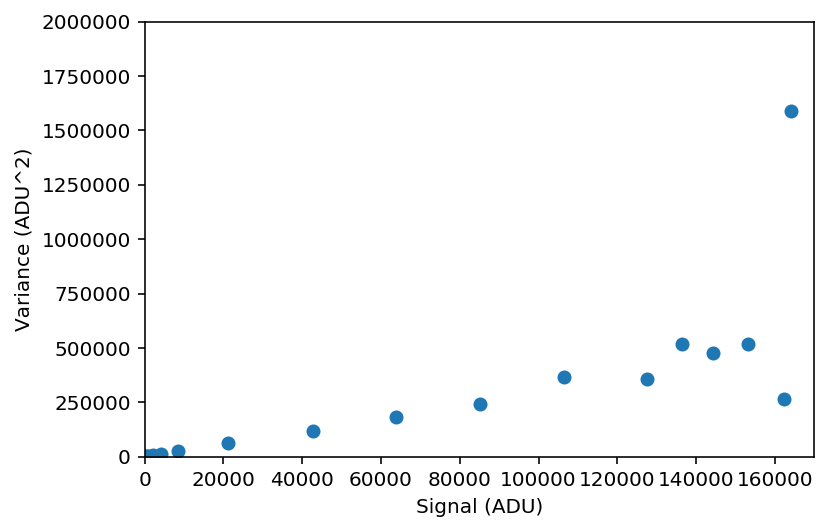

In [130]:
plt.figure()
plt.scatter(signal, variance)
plt.xlabel('Signal (ADU)')
plt.ylabel('Variance (ADU^2)')
plt.axis([0,170000,0,2000000])

Next step would be to get all the amps from all the detectors and to fit these curves to measure the individual gains.